## Fine-tune Borzoi to predict RNA-seq coverage

In [1]:
import numpy as np
import pandas as pd
import torch
import os
import importlib
from tqdm import tqdm
import time
from grelu.io.bed import read_bed
from grelu.resources import load_model
from grelu.utils import make_list
from grelu.data.preprocess import filter_chrom_ends
import grelu.visualize
from grelu.data.dataset import TileDBSeqDataset

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
experiment='tutorial_7'
if not os.path.exists(experiment):
    os.makedirs(experiment)

In [3]:
experiments = {
    'ENCFF732DIV':'ENCSR373XVN', 'ENCFF411BAA':'ENCSR967DSJ', 'ENCFF575FTH':'ENCSR215KUO', 
    'ENCFF207LAN':'ENCSR701YIC', 'ENCFF110EQO':'ENCSR575MQY', 'ENCFF729CEE':'ENCSR892WHX'
}
df = pd.DataFrame.from_dict(experiments, orient='index').reset_index()
df['url'] = df['index'].apply(lambda x:f'https://www.encodeproject.org/files/{x}/@@download/{x}.bigWig')
df.columns=['bigwig_ID', 'experiment_ID', 'url']
df['basename'] = df.url.apply(os.path.basename)
df.to_csv('encode_acc.csv', index=False)

## Load intervals

In [4]:
#!wget https://raw.github.com/calico/borzoi/refs/heads/main/data/sequences_human.bed.gz

In [5]:
intervals = read_bed('sequences_human.bed.gz')
intervals = intervals.rename(columns={3:'fold'})

val_intervals = intervals[intervals['fold'] == 'fold4'].reset_index(drop=True)
test_intervals = intervals[intervals['fold'] == 'fold3'].reset_index(drop=True)
train_intervals = intervals[~intervals['fold'].isin(['fold3', 'fold4'])].reset_index(drop=True)

len(train_intervals), len(val_intervals), len(test_intervals)

(41699, 6910, 6888)

In [6]:
train_intervals = filter_chrom_ends(train_intervals, genome='hg38', pad=200000)
val_intervals = filter_chrom_ends(val_intervals, genome='hg38', pad=200000)
test_intervals = filter_chrom_ends(test_intervals, genome='hg38', pad=200000)
len(train_intervals), len(val_intervals), len(test_intervals)

Keeping 41622 intervals
Keeping 6886 intervals
Keeping 6880 intervals


(41622, 6886, 6880)

## Load RNA-seq experiments

In [7]:
tasks = pd.read_csv('encode_acc.csv')
tasks

,bigwig_ID,experiment_ID,url,basename
0,ENCFF732DIV,ENCSR373XVN,https://www.encodeproject.org/files/ENCFF732DI...,ENCFF732DIV.bigWig
1,ENCFF411BAA,ENCSR967DSJ,https://www.encodeproject.org/files/ENCFF411BA...,ENCFF411BAA.bigWig
2,ENCFF575FTH,ENCSR215KUO,https://www.encodeproject.org/files/ENCFF575FT...,ENCFF575FTH.bigWig
3,ENCFF207LAN,ENCSR701YIC,https://www.encodeproject.org/files/ENCFF207LA...,ENCFF207LAN.bigWig
4,ENCFF110EQO,ENCSR575MQY,https://www.encodeproject.org/files/ENCFF110EQ...,ENCFF110EQO.bigWig
5,ENCFF729CEE,ENCSR892WHX,https://www.encodeproject.org/files/ENCFF729CE...,ENCFF729CEE.bigWig


## Make TileDB datasets

In [3]:
tdb_dir = 'tutorial_7/tdb/intervals/'

In [7]:
%%time

train_ds = TileDBSeqDataset(
    tdb_path = os.path.join(tdb_dir, 'train'),
    #intervals = train_intervals,
    #bin_size=32,
    #aggfunc='sum',
    #bw_files=tasks.basename.tolist(),
    #tasks=tasks,
    #genome='hg38',
    seq_len=524288,
    label_len=196608,
    rc = True,
    max_seq_shift=3,
    max_pair_shift=640,
    num_threads=32,
    chunk_size=1024,
    label_transform_func=np.sqrt,
    augment_mode='random'
)

Reading existing TileDB file
The following parameters will be loaded from TileDB:
n_seqs: 41622
n_tasks: 6
aggfunc: sum
bin_size: 32
Loaded 41699 intervals from tileDB
Loaded the following tasks from TileDB: [0, 1, 2, 3, 4, 5]
CPU times: user 141 ms, sys: 477 ms, total: 618 ms
Wall time: 166 ms


In [8]:
len(train_ds)

41622

In [10]:
%%time

val_ds = TileDBSeqDataset(
    tdb_path = os.path.join(tdb_dir, 'val'),
    #intervals = val_intervals,
    #bin_size=32,
    #aggfunc='sum',
    #bw_files=tasks.basename.tolist(),
    #tasks=tasks,
    #genome='hg38',
    seq_len=524288,
    label_len=196608,
    rc = False,
    max_seq_shift=0,
    max_pair_shift=0,
    num_threads=32,
    chunk_size=1024,
    label_transform_func=np.sqrt
)

Reading existing TileDB file
The following parameters will be loaded from TileDB:
n_seqs: 6886
n_tasks: 6
aggfunc: sum
bin_size: 32
Loaded 6910 intervals from tileDB
Loaded the following tasks from TileDB: [0, 1, 2, 3, 4, 5]
CPU times: user 134 ms, sys: 271 ms, total: 406 ms
Wall time: 126 ms


In [11]:
%%time

test_ds = TileDBSeqDataset(
    tdb_path = os.path.join(tdb_dir, 'test'),
    #intervals = test_intervals,
    #bin_size=32,
    #aggfunc='sum',
    #bw_files=tasks.basename.tolist(),
    #tasks=tasks,
    #genome='hg38',
    seq_len=524288,
    label_len=196608,
    rc = False,
    max_seq_shift=0,
    max_pair_shift=0,
    num_threads=32,
    chunk_size=1024,
    label_transform_func=np.sqrt,
)

Reading existing TileDB file
The following parameters will be loaded from TileDB:
n_seqs: 6880
n_tasks: 6
aggfunc: sum
bin_size: 32
Loaded 6888 intervals from tileDB
Loaded the following tasks from TileDB: [0, 1, 2, 3, 4, 5]
CPU times: user 169 ms, sys: 241 ms, total: 410 ms
Wall time: 131 ms


## Load Borzoi model

In [12]:
model = load_model(project="borzoi", model_name="human_fold0")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anony-mouse-180959755991866352. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_fold0:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


## Visualize test data

In [13]:
output_interval = test_intervals.head(1)
output_interval

,chrom,start,end,fold
0,chr5,41626145,41822753,fold3


In [20]:
output_start = output_interval.start[0]
output_end = output_interval.end[0]
output_len = output_end - output_start
print(output_len)

196608


In [14]:
import grelu.io.genome

exons = grelu.io.genome.read_gtf("hg38", features="exon")
exons.head(3)

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
1,chr1,11874,12227,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
2,chr1,12613,12721,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
3,chr1,13221,14409,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."


In [15]:
import grelu.data.preprocess

output_exons = grelu.data.preprocess.filter_overlapping(
    exons,
    ref_intervals=output_interval,
    method="all" # return the exon if there any overlap at all with the output interval. Set to 'all' for completely contained exons.
)
output_exons.head(3)

Keeping 68 intervals


,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
3195353,chr5,41730065,41731770,OXCT1,genomepy,exon,.,-,.,"gene_id ""OXCT1""; transcript_id ""NM_001364303.2..."
3195355,chr5,41739390,41739491,OXCT1,genomepy,exon,.,-,.,"gene_id ""OXCT1""; transcript_id ""NM_001364303.2..."
3195357,chr5,41749527,41749607,OXCT1,genomepy,exon,.,-,.,"gene_id ""OXCT1""; transcript_id ""NM_001364303.2..."


In [16]:
output_genes = grelu.data.preprocess.merge_intervals_by_column(
    output_exons, group_col="gene_name"
)
output_genes

,gene_name,chrom,start,end,strand
0,OXCT1,chr5,41730065,41807438,-


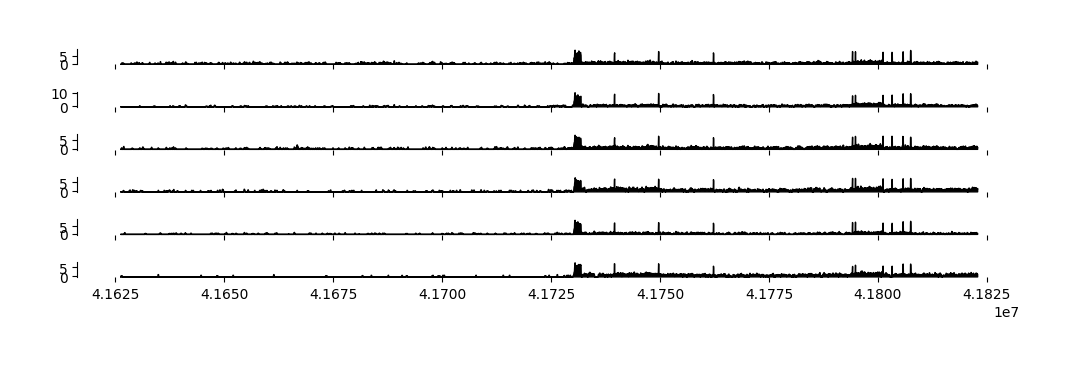

In [14]:
fig = grelu.visualize.plot_tracks(test_ds[0][1], start_pos=interval.start, end_pos=interval.end, figsize=(10,3))

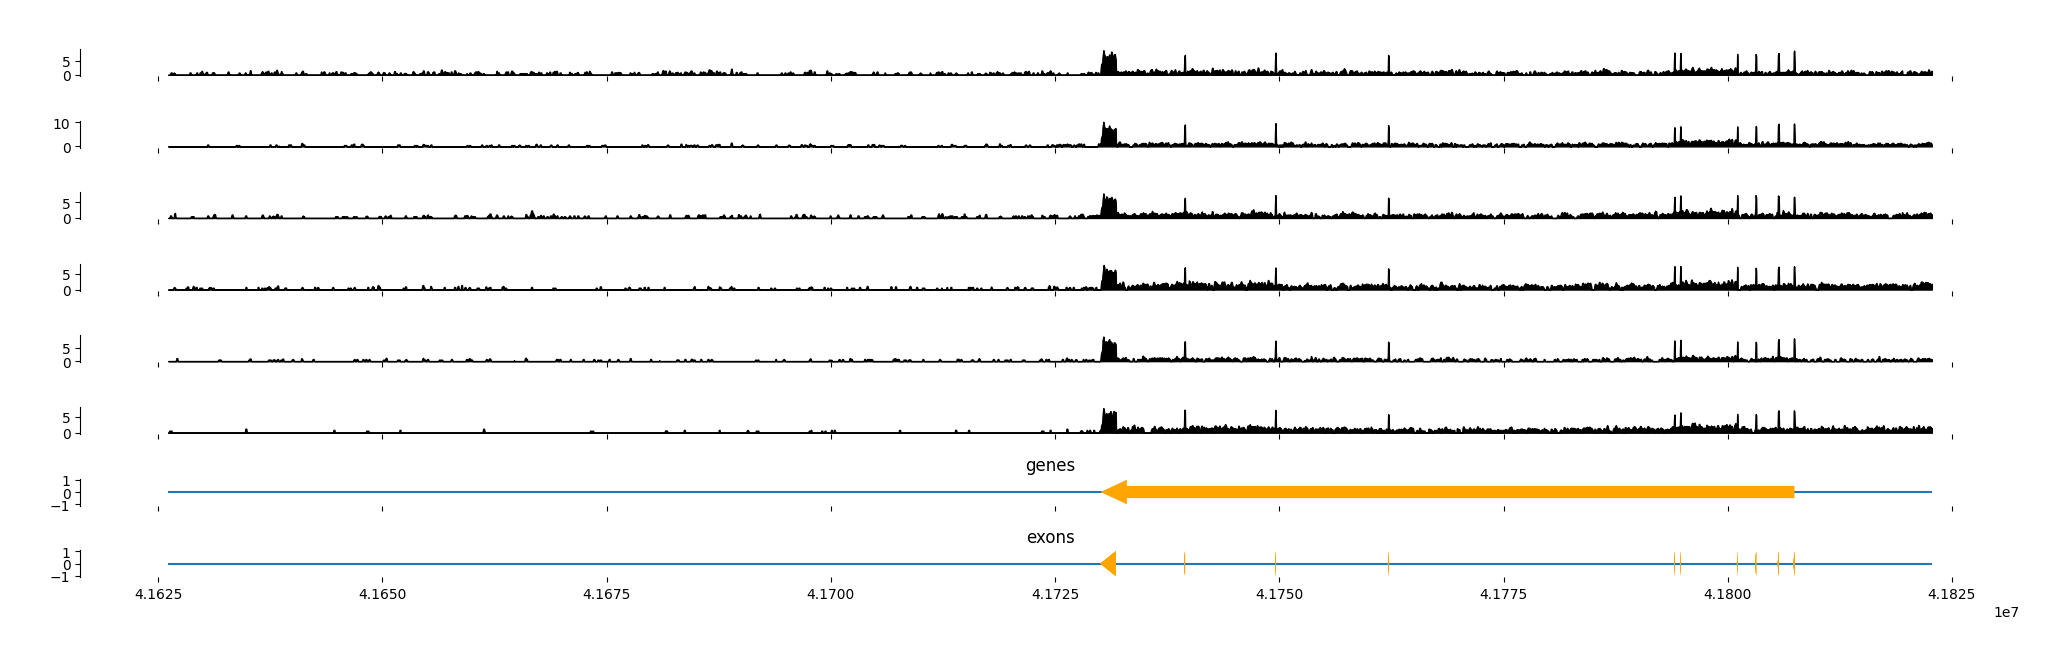

In [22]:
fig = grelu.visualize.plot_tracks(
    test_ds[0][1], # Outputs to plot
    start_pos=output_start, # Start coordinate for x-axis
    end_pos=output_end, # End coordinate for x-axis
    figsize=(20, 6),
    annotations={"genes":output_genes, "exons":output_exons} # Dictionary of annotation dataframes
)

## Fine-tune Borzoi model head

In [ ]:
model.tune_on_dataset(
    train_dataset=train_ds,
    val_dataset=val_ds,
    devices=5,
    batch_size=12,
    num_workers=0,
    final_pool_func= None,
    freeze_embedding=True,
    task='regression',
    loss='poisson_multinomial',
    multinomial_axis="length",
    total_weight=.5,
    max_epochs=3,
    lr=1e-4,
    precision='16-mixed',
    save_dir=experiment,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [15:48<00:00,  0.60it/s]{'val_mse': tensor(1.2424, device='cuda:5'), 'val_pearson': tensor(-0.0163, device='cuda:5')}
validation loss: 3.225902795791626
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [15:48<00:00,  0.60it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                   | Params | Mode 
----------------------------------------------------------------
0 | model        | BorzoiModel            | 171 M  | train
1 | transform    | Identity               | 0      | train
2 | activation   | Exp                    | 0      | train
3 | loss         | PoissonMultinomialLoss | 0      | train
4 | val_metrics  | MetricCollection       | 0      | train
5 | test_metrics | MetricCollection       | 0      | train
----------------------------------------------------------------
11.5 K    Trainable params
171 M     Non-trainable params
171 M     Total params
685.134   Total estimated model params size (MB)
399       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                                                                                                                                   | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  0.75it/s]{'val_mse': tensor(1.7021, device='cuda:5'), 'val_pearson': tensor(-0.0223, device='cuda:5')}
validation loss: 3.3063502311706543
                                                                                                                                                                                                                                           

/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3469/3469 [1:40:47<00:00,  0.57it/s, v_num=1, train_loss_step=4.080]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [15:56<00:00,  0.60it/s]{'val_mse': tensor(0.6293, device='cuda:5'), 'val_pearson': tensor(0.6343, device='cuda:5')}
validation loss: 2.9956467151641846

Epoch 1:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2902/3469 [1:24:14<1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3469/3469 [1:40:58<00:00,  0.57it/s, v_num=1, train_loss_step=2.110, train_loss_epoch=2.990]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 574/574 [16:13<00:00,  0.59it/s]{'val_mse': tensor(0.6122, device='cuda:5'), 'val_pearson': tensor(0.6460, device='cuda:5')}
validation loss: 2.9933879375457764

Epoch 2:  44%|█████████████████████████████████████████████████████████                                                                        | 1535/3469 [44:52<5

## Load best model checkpoint

In [ ]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)

In [ ]:
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

## Compute bin-level metrics

In [ ]:
test_metrics = model.test_on_dataset(
    test_ds, batch_size=12, devices=5, num_workers=0
)

test_metrics

## Visualize predictions